In [2]:
import pandas as pd

# 파일 경로 지정
file_path = 'daily_sentiment_summary.csv'

# CSV 파일을 DataFrame으로 불러오기
df = pd.read_csv(file_path)

# 불러온 데이터 확인 (선택)
print(df.head())

           날짜  평균감성점수  게시글수  평균신뢰도                            감성분포
0  2025.06.08  -0.501     1  0.501                       {'부정': 1}
1  2025.06.09   0.273   216  0.501  {'긍정': 166, '부정': 49, '중립': 1}
2  2025.06.10   0.280   211  0.504           {'긍정': 164, '부정': 47}
3  2025.06.11   0.231   140  0.497  {'긍정': 101, '부정': 37, '중립': 2}
4  2025.06.12   0.258   340  0.498  {'긍정': 255, '부정': 81, '중립': 4}


In [6]:
from pykrx import stock
import pandas as pd
from datetime import datetime

def get_daily_returns(ticker, start_date="2022-01-01", end_date=None, save_csv=True):
    """
    한국 주식 티커의 일일 수익률을 계산하여 DataFrame 및 CSV로 저장합니다.
    Parameters:
    - ticker: str, 예: "005930" (삼성전자)
    - start_date: str, "YYYY-MM-DD"
    - end_date: str, "YYYY-MM-DD" (기본: 오늘)
    - save_csv: bool, True면 CSV로 저장
    Returns:
    - DataFrame: 날짜별 수익률 포함
    """
    if end_date is None:
        end_date = datetime.today().strftime("%Y-%m-%d")
    # 1. 일별 OHLCV 데이터 가져오기
    df = stock.get_market_ohlcv_by_date(start_date, end_date, ticker)
    # 2. 2일 뒤 종가 대비 수익률 계산
    df['Return'] = df['종가'].shift(1) / df['종가'] - 1
    # 3. 날짜 인덱스 리셋
    df.reset_index(inplace=True)
    # 4. 필요한 컬럼만 정리
    df = df[['날짜', '종가', 'Return']]
    # 5. 저장
    if save_csv:
        filename = f"{ticker}_return.csv"
        df.to_csv(filename, index=False)
        print(f"[✓] Saved to {filename}")
    return df

df1 = get_daily_returns("042940", start_date="2024-06-21")
print(df1.tail(3))

[✓] Saved to 042940_return.csv
            날짜     종가    Return
240 2025-06-20  13810  0.060101
241 2025-06-23  13250  0.042264
242 2025-06-24  13670 -0.030724


In [7]:
df_reset = df.reset_index()

# 2. 날짜 컬럼 형식 통일 (datetime)
df_reset['날짜'] = pd.to_datetime(df_reset['날짜'])
df1['날짜'] = pd.to_datetime(df1['날짜'])

# 3. 날짜 기준으로 병합 (inner join)
df2 = pd.merge(df1, df_reset, on='날짜', how='inner')

df2.tail(3)

,날짜,종가,Return,index,평균감성점수,게시글수,평균신뢰도,감성분포
9,2025-06-20,13810,0.060101,12,0.292,88,0.498,"{'긍정': 69, '부정': 18, '중립': 1}"
10,2025-06-23,13250,0.042264,15,0.225,83,0.504,"{'긍정': 60, '부정': 23}"
11,2025-06-24,13670,-0.030724,16,0.352,20,0.503,"{'긍정': 17, '부정': 3}"


✅ 시차별 상관관계:
     Lag  Correlation
0    -3    -0.210741
1    -2     0.393066
2    -1     0.008224
3     0    -0.197382
4     1    -0.164498
5     2    -0.025397
6     3     0.158546
7     4    -0.031235
8     5     0.376855
9     6    -0.476752
10    7    -0.396667

🎯 가장 높은 상관관계: lag 6일, 상관계수 = -0.4768


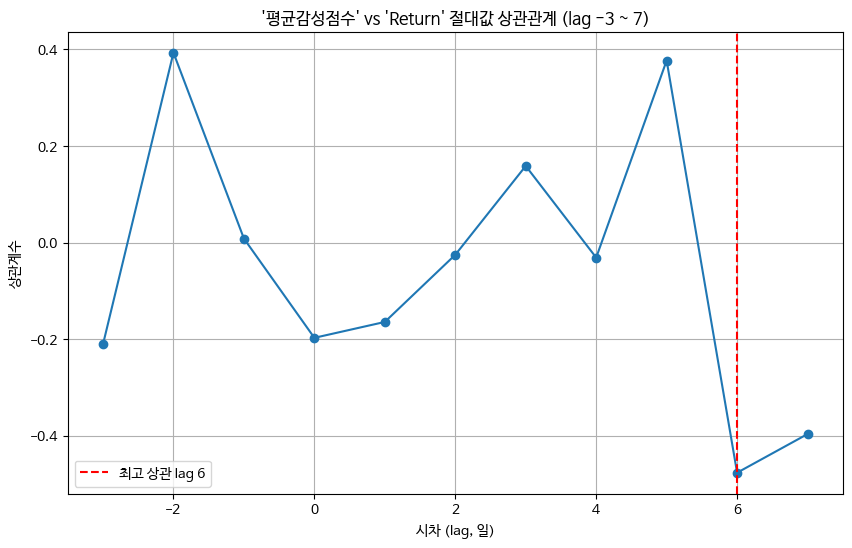

(    Lag  Correlation
 0    -3    -0.210741
 1    -2     0.393066
 2    -1     0.008224
 3     0    -0.197382
 4     1    -0.164498
 5     2    -0.025397
 6     3     0.158546
 7     4    -0.031235
 8     5     0.376855
 9     6    -0.476752
 10    7    -0.396667,
 Lag            6.000000
 Correlation   -0.476752
 Name: 9, dtype: float64)

In [9]:
import matplotlib.pyplot as plt
def lagged_correlation_analysis_return_ratio(df, ratio_col='평균감성점수', return_col='Return', date_col='날짜', min_lag=-3, max_lag=7):
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])

    lag_results = []

    for lag in range(min_lag, max_lag + 1):
        temp_df = df.copy()

        # 시차에 따라 Return 절대값 시프트 (음수 lag: 과거 시점, 양수 lag: 미래 시점)
        temp_df[f'{return_col}_lag_{lag}'] = temp_df[return_col].shift(-lag).abs()
        
        # ratio, shifted Return 둘 다 결측치 제거
        clean_df = temp_df.dropna(subset=[ratio_col, f'{return_col}_lag_{lag}'])

        corr = clean_df[ratio_col].corr(clean_df[f'{return_col}_lag_{lag}'])
        lag_results.append({'Lag': lag, 'Correlation': corr})

    lag_corr_df = pd.DataFrame(lag_results)

    best_row = lag_corr_df.loc[lag_corr_df['Correlation'].abs().idxmax()]

    print("✅ 시차별 상관관계:\n", lag_corr_df)
    print(f"\n🎯 가장 높은 상관관계: lag {int(best_row['Lag'])}일, 상관계수 = {best_row['Correlation']:.4f}")

    plt.figure(figsize=(10,6))
    plt.plot(lag_corr_df['Lag'], lag_corr_df['Correlation'], marker='o', linestyle='-')
    plt.axvline(best_row['Lag'], color='red', linestyle='--', label=f"최고 상관 lag {int(best_row['Lag'])}")
    plt.title(f"'{ratio_col}' vs '{return_col}' 절대값 상관관계 (lag {min_lag} ~ {max_lag})")
    plt.xlabel("시차 (lag, 일)")
    plt.ylabel("상관계수")
    plt.legend()
    plt.grid(True)
    plt.show()

    return lag_corr_df, best_row

lagged_correlation_analysis_return_ratio(df2, ratio_col='평균감성점수', return_col='Return', date_col='날짜', min_lag=-3, max_lag=7)